## II. Bakery Dataset

In [17]:
import os
import sys
from choice_learn.basket_models import AleaCarta

os.environ["CUDA_VISIBLE_DEVICES"] = ""

sys.path.append("../../")
print(os.getcwd())

/Users/michael.teboul/Documents/choice-learn-1/notebooks


In [18]:
from choice_learn.basket_models.data.preprocessing import load_bakery


data = load_bakery()
print(data)
print(f"\nThe TripDataset 'data' contains {data.n_items} distinct items that appear in {data.n_samples} transactions carried out at {data.n_stores} point(s) of sale with {data.n_assortments} different assortments.")

Files : ['uchoice-Bakery', 'uchoice-Bakery/uchoice-Bakery.txt', 'uchoice-Bakery/uchoice-Bakery-5-25.txt', 'uchoice-Bakery/README.txt']
TripDataset with 75000 trips

The TripDataset 'data' contains 51 distinct items that appear in 266209 transactions carried out at 1 point(s) of sale with 1 different assortments.


In [36]:
latent_sizes = {"preferences": 6, "price": 3, "season": 3}
n_negative_samples = 2
optimizer = "adam"
lr = 1e-2
epochs = 30
# epochs = 1000
batch_size = 32



In [37]:
model = AleaCarta(
    # item_intercept=True,
    item_intercept=True,
    price_effects=False,
    seasonal_effects=False,
    latent_sizes=latent_sizes,
    n_negative_samples=n_negative_samples,
    optimizer=optimizer,
    lr=lr,
    epochs=epochs,
    batch_size=batch_size,
)

model.instantiate(n_items=data.n_items, n_stores=data.n_stores)

In [ ]:
history = model.fit(trip_dataset=data[:1000], verbose=1, val_dataset=data[8000:9000])


Epoch 5 Train Loss 0.8106:  20%|██        | 6/30 [01:37<06:28, 16.18s/it]

/var/folders/4n/g7n4s25944s77p645cqllzgh0000gp/T/ipykernel_10468/4062289676.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


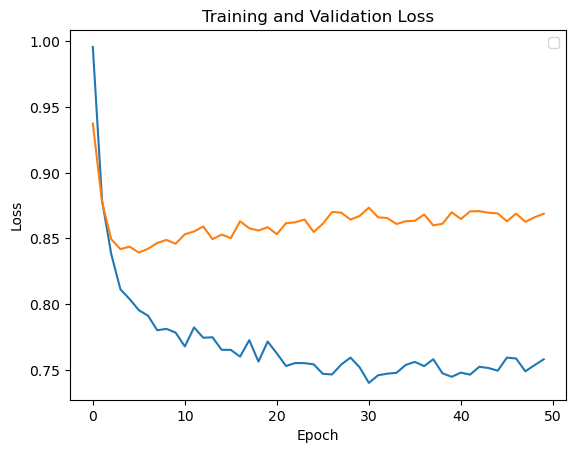

In [ ]:
plt.plot(history["train_loss"])
plt.plot(history["val_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")



plt.show()